## Testing model at varying levels of dropout

I want to load my model and test how it performs on validation data and train data on varying levels of dropout.

In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from datamodule import WikipediaDataModule

import os

num_cpus = os.cpu_count()
dm = WikipediaDataModule(
    document_model_name_or_path="roberta-base",
    profile_model_name_or_path="google/tapas-base",
    max_seq_length=128,
    dataset_name='wiki_bio',
    dataset_train_split='train[:1]', # not used
    dataset_val_split='val[:20%]',
    dataset_version='1.2.0',
    word_dropout_ratio=0.0,
    word_dropout_perc=0.0,
    num_workers=1,
    train_batch_size=64,
    eval_batch_size=64
)
dm.setup("fit")

Initializing WikipediaDataModule with num_workers = 1 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:1]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)


loading wiki_bio[1.2.0] split val[:20%]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-b98e3ae8bfedd5c6.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-7d07543b6205ca87.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-7440752484ad8676.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-2c6f94b0d2dcc153.arrow


In [2]:
from model import CoordinateAscentModel

# model that was trained at the link given above, gets >99% validation accuracy,
# and is trained with word dropout!

from model_cfg import model_paths_dict

checkpoint_path = model_paths_dict["model_5"]

model = CoordinateAscentModel.load_from_checkpoint(
    checkpoint_path,
    document_model_name_or_path="roberta-base",
    profile_model_name_or_path="google/tapas-base",
    learning_rate=1e-5,
    pretrained_profile_encoder=False,
    lr_scheduler_factor=0.5,
    lr_scheduler_patience=1,
    train_batch_size=1,
    num_workers=1,
    gradient_clip_val=10.0,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 1e-05 and patience 1


In [3]:
import numpy as np
import torch
import tqdm

def precompute_profile_embeddings():
    model.profile_model.cuda()
    model.profile_model.eval()

    model.val_profile_embeddings = np.zeros((len(dm.val_dataset), model.profile_embedding_dim))
    for val_batch in tqdm.tqdm(dm.val_dataloader()[0], desc="Precomputing val embeddings", colour="green", leave=False):
        with torch.no_grad():
            profile_embeddings = model.forward_profile(batch=val_batch)
        model.val_profile_embeddings[val_batch["text_key_id"]] = profile_embeddings.cpu()
    model.val_profile_embeddings = torch.tensor(model.val_profile_embeddings, dtype=torch.float32)
    model.profile_model.train()

precompute_profile_embeddings()

In [4]:
model.profile_model.cuda()
model.document_model.cuda()
model.document_embed.cuda()
model.document_model.eval()
model.val_profile_embeddings = model.val_profile_embeddings.cuda()

In [26]:
from torch.utils.data import DataLoader
from masking_tokenizing_dataset import MaskingTokenizingDataset

val_tokenizing_dataset = MaskingTokenizingDataset(
    dm.val_dataset,
    document_tokenizer=dm.document_tokenizer,
    profile_tokenizer=dm.profile_tokenizer,
    max_seq_length=dm.max_seq_length,
    word_dropout_ratio=0.0,
    word_dropout_perc=0.0,
    profile_row_dropout_perc=0.0,
    sample_spans=False,
    document_types=["document"],
    is_train_dataset=True
)

import tqdm

accs = {}
num_samples = 1000

for dropout_stopwords in [True, False]:
    print(f'*** dropout_stopwords = {dropout_stopwords}')
    for dropout_amount in np.arange(0.0, 1.0+.1, 0.1): # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        num_correct = 0
        num_total = 0
        print(f'Testing with dropout at {dropout_amount*100}%')
        val_tokenizing_dataset.masking_span_sampler.word_dropout_perc = dropout_amount
        val_tokenizing_dataset.masking_span_sampler.word_dropout_ratio = 1.0
        val_tokenizing_dataset.masking_span_sampler.dropout_stopwords = dropout_stopwords
        dropout_dataloader = DataLoader(
            [val_tokenizing_dataset[i] for i in range(num_samples)],
            batch_size=128,
            num_workers=min(dm.num_workers, 8),
            shuffle=False
        )
        for batch in tqdm.tqdm(dropout_dataloader, leave=False):
            with torch.no_grad():
                val_emb = model.forward_document(batch=batch, document_type='document')
            pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)
            true_idxs = batch['text_key_id'].cuda()
            num_correct += (pred_idxs == true_idxs).sum().item()
            num_total += len(true_idxs)

        acc = num_correct / num_total
        print(acc)
        accs[(dropout_amount, dropout_stopwords)] = acc

*** dropout_stopwords = True
Testing with dropout at 0.0%


Exception ignored in: <function tqdm.__del__ at 0x7f570788bdc0>
Traceback (most recent call last):
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
  File "/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/tqdm/std.py", line 1276, in close
AttributeError: 'tqdm' object has no attribute 'last_print_t'


0.998
Testing with dropout at 10.0%


0.999
Testing with dropout at 20.0%


0.992
Testing with dropout at 30.000000000000004%


0.994
Testing with dropout at 40.0%


0.985
Testing with dropout at 50.0%


0.948
Testing with dropout at 60.00000000000001%


0.9
Testing with dropout at 70.0%


0.8
Testing with dropout at 80.0%


0.653
Testing with dropout at 90.0%


0.399
Testing with dropout at 100.0%


0.066
*** dropout_stopwords = False
Testing with dropout at 0.0%


0.998
Testing with dropout at 10.0%


0.995
Testing with dropout at 20.0%


0.993
Testing with dropout at 30.000000000000004%


0.987
Testing with dropout at 40.0%


0.978
Testing with dropout at 50.0%


0.952
Testing with dropout at 60.00000000000001%


0.919
Testing with dropout at 70.0%


0.842
Testing with dropout at 80.0%


0.733
Testing with dropout at 90.0%


0.531
Testing with dropout at 100.0%


0.23


In [27]:
import pandas as pd

accs_rows = [(*k, v) for k,v in accs.items()]
df = pd.DataFrame(data=accs_rows, columns=['dropout %', 'no_stopwords', 'accuracy'])
df.head()

,dropout %,no_stopwords,accuracy
0,0.0,True,0.998
1,0.1,True,0.999
2,0.2,True,0.992
3,0.3,True,0.994
4,0.4,True,0.985


Text(0.5, 1.0, 'Model accuracy across levels of word dropout')

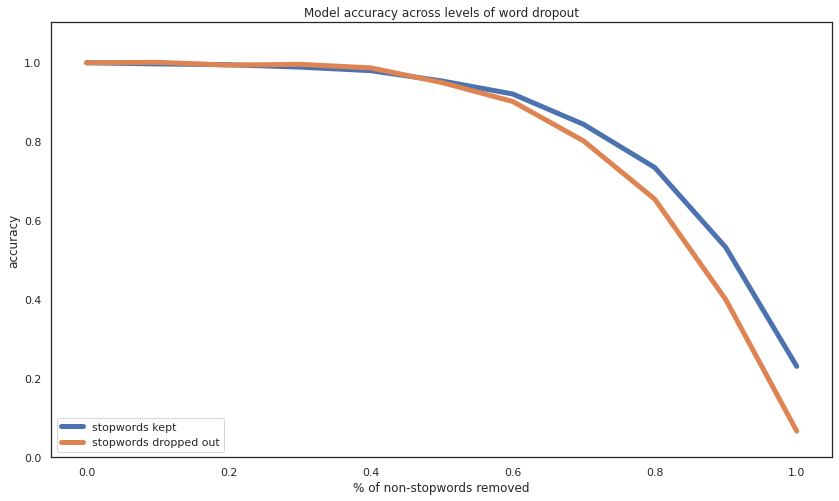

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("white")

plt.figure(figsize=(14,8))

ax = sns.lineplot(data=df, linewidth=5, x='dropout %', y='accuracy', hue='no_stopwords')
ax.set_xlabel("% of non-stopwords removed")
ax.set_ylabel("accuracy")
ax.set_ylim(bottom=0.0, top=1.1)
    
plt.legend(title=None, loc='lower left', labels=['stopwords kept', 'stopwords dropped out'])
plt.title('Model accuracy across levels of word dropout')

## How much do document length and profile length correlate?

In [42]:
dm.val_dataset[0].keys()

dict_keys(['input_text', 'target_text', 'name', 'document', 'profile', 'profile_keys', 'profile_values', 'text_key', 'document_redact_lexical', 'document_redact_ner', 'text_key_id'])

In [52]:
def get_num_words(ex):
    ex['doc_words'] = ex['target_text'].split(' ')
    ex['prof_val_words'] = [k for r in ex['profile_values'].split('||') for k in r.split()]
    return ex

In [56]:
val_dataset = dm.val_dataset.map(get_num_words)

Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-c1d5f8156466a822.arrow


In [60]:
words_df = pd.DataFrame([(len(ex['doc_words']), len(ex['prof_val_words'])) for ex in val_dataset], columns=['doc_words_len', 'prof_val_words_len'])

In [61]:
words_df.head()

,doc_words_len,prof_val_words_len
0,83,60
1,12,6
2,23,98
3,32,40
4,26,31


Text(0.5, 0, 'number of words in profile')

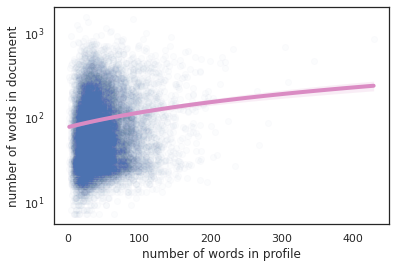

In [101]:
dot_color = sns.color_palette()[0]
line_color = sns.color_palette()[6]

ax = sns.regplot(data=words_df, x='prof_val_words_len', y='doc_words_len',
                scatter_kws={'alpha':0.02, 'color': dot_color}, line_kws={"color": line_color, 'linewidth': 4})
ax.set_yscale('log')
ax.set_ylabel('number of words in document')
ax.set_xlabel('number of words in profile')

In [95]:
sns.color_palette()[1]

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]